In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.tools.plotting import parallel_coordinates

import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
# rcParams['figure.figsize'] = 12, 4
from scipy import stats
import math


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from sklearn import preprocessing

D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_excel('data_accidentForPapaer_17.11.13.xlsx')
data = data[data['路面附着系数'].isnull()]
print(len(data))
data_roadGrade_withoutJianyi = data[~data['事故类型'].isin(['简易程序事故'])]
print(len(data_roadGrade_withoutJianyi))

data_roadGrade_withoutJianyi.drop(['路面附着系数'],axis=1,inplace=True)
data_roadGrade_withoutJianyi \
                        = data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi['是否节假日'].notnull()\
                        &data_roadGrade_withoutJianyi['事故多发点段'].notnull()\
                        &data_roadGrade_withoutJianyi['交通信号方式（控制）'].notnull()\
                        &data_roadGrade_withoutJianyi['公里数'].notnull()\
                        &data_roadGrade_withoutJianyi['其他交通安全设施不全'].notnull()\
                        &data_roadGrade_withoutJianyi['在道路横断面位置'].notnull()\
                        &data_roadGrade_withoutJianyi['地形'].notnull()\
                        &data_roadGrade_withoutJianyi['所辖乡镇'].notnull()\
                        &data_roadGrade_withoutJianyi['照明条件'].notnull()\
                        &data_roadGrade_withoutJianyi['能见度'].notnull()\
                        &data_roadGrade_withoutJianyi['路侧防护设施类型'].notnull()\
                        &data_roadGrade_withoutJianyi['路口路段类型'].notnull()\
                        &data_roadGrade_withoutJianyi['路表情况'].notnull()\
                        &data_roadGrade_withoutJianyi['路面状况'].notnull()\
                        &data_roadGrade_withoutJianyi['路面结构'].notnull()\
                        &data_roadGrade_withoutJianyi['道路安全属性'].notnull()\
                        &data_roadGrade_withoutJianyi['道路安全隐患督办等级'].notnull()\
                        &data_roadGrade_withoutJianyi['道路物理隔离'].notnull()\
                        &data_roadGrade_withoutJianyi['道路类型'].notnull()\
                        &data_roadGrade_withoutJianyi['道路线型'].notnull()]

#整合路宽
data_way = data_roadGrade_withoutJianyi[['单向路宽','双向路宽']]
data_way.columns=['oneWay','twoWay']

#填充空值为-1
data_way.fillna(-1,inplace=True)

def isTwowayRoad(row,oneWay,twoWay):
    if row[oneWay] == -1 and row[twoWay] == -1:
        return np.nan
    elif row[oneWay] == -1:
        return '是'
    elif  row[twoWay] == -1:
        return  '否'

def getRoadWidth(row,oneWay,twoWay):
    if row[oneWay] == -1 and row[twoWay] == -1:
        return np.nan
    elif row[oneWay] == -1:
        return row[twoWay]
    elif  row[twoWay] == -1:
        return  row[oneWay]

data_isTwoWay = pd.DataFrame(data_way.apply(isTwowayRoad, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['isTwoWay'])
data_roadWidth = pd.DataFrame(data_way.apply(getRoadWidth, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['roadWidth'])

data_roadGrade_withoutJianyi.insert(value=data_isTwoWay,column='是否双道',loc=3)
data_roadGrade_withoutJianyi.insert(value=data_roadWidth,column='路宽',loc=4)

# pd.DataFrame(data_attach_notnull[(data_attach_notnull['路宽']==-1)])[['是否双道','路宽','单向路宽','双向路宽']]
data_roadGrade_withoutJianyi.drop(['单向路宽','双向路宽'],axis=1,inplace=True)
del data_way,data_isTwoWay,data_roadWidth

nan_columns = {}
length_data = len(data_roadGrade_withoutJianyi)
for i in range(len(data_roadGrade_withoutJianyi.columns)): 
    odds = sum(data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi.columns[i]].isnull())/length_data
    nan_columns[data_roadGrade_withoutJianyi.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+': '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()
        
data_roadGrade_withoutJianyi = data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi['是否双道'].notnull()\
                                                        &data_roadGrade_withoutJianyi['中央隔离设施'].notnull()]
print(len(data_roadGrade_withoutJianyi))
data_roadGrade_withoutJianyi.drop(['公路行政等级'],axis=1,inplace=True)

196169
3052


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramFiles\Anaconda3\lib\site-packages\pandas\core\frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


中央隔离设施: 0.240349599417  是否节假日: 0.0  是否白天: 0.0  是否双道: 0.28987618354  
路宽: 0.28987618354  事故地点: 0.0  事故多发点段: 0.0  事故类型: 0.0  
交通信号方式（控制）: 0.0  交通标志标线完善: 0.0  公路行政等级: 0.402039329934  公里数: 0.0  
其他交通安全设施不全: 0.0  在道路横断面位置: 0.0  地形: 0.0  天气: 0.0  
所辖乡镇: 0.0  星期: 0.0  是否运载危险物品: 0.0  照明条件: 0.0  
能见度: 0.0  行政区划: 0.0  路侧防护设施类型: 0.0  路口路段类型: 0.0  
路号: 0.0  路表情况: 0.0  路面状况: 0.0  路面结构: 0.0  
道路安全属性: 0.0  道路安全隐患督办等级: 0.0  道路物理隔离: 0.0  道路类型: 0.0  
道路线型: 0.0  长下坡路段: 0.0  774


In [45]:
nan_columns = {}
length_data = len(data_roadGrade_withoutJianyi)
for i in range(len(data_roadGrade_withoutJianyi.columns)): 
    odds = sum(data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi.columns[i]].isnull())/length_data
    nan_columns[data_roadGrade_withoutJianyi.columns[i]] = odds
j = 0
for i in nan_columns:
    print(i+': '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()
        
print(len(data_roadGrade_withoutJianyi))

中央隔离设施: 0.0  是否节假日: 0.0  是否白天: 0.0  是否双道: 0.0  
路宽: 0.0  事故地点: 0.0  事故多发点段: 0.0  事故类型: 0.0  
交通信号方式（控制）: 0.0  交通标志标线完善: 0.0  公里数: 0.0  其他交通安全设施不全: 0.0  
在道路横断面位置: 0.0  地形: 0.0  天气: 0.0  所辖乡镇: 0.0  
星期: 0.0  是否运载危险物品: 0.0  照明条件: 0.0  能见度: 0.0  
行政区划: 0.0  路侧防护设施类型: 0.0  路口路段类型: 0.0  路号: 0.0  
路表情况: 0.0  路面状况: 0.0  路面结构: 0.0  道路安全属性: 0.0  
道路安全隐患督办等级: 0.0  道路物理隔离: 0.0  道路类型: 0.0  道路线型: 0.0  
长下坡路段: 0.0  index: 0.0  774


# 获取CNN训练集

## 获取某路号出现最多的道路相关属性

In [50]:
# len(data_roadGrade_withoutJianyi.groupby(['路号']))
info = {}
for name,group in data_gbRoadNo:
        for i in group.columns:
            if i in roadColumns:
                info[i] = group[i].value_counts().index[0]    
        break
print(info)
# 事故多发点段,交通信号方式,交通标志标线完善,其他交通安全设施不全,路侧防护设施类型,路口路段类型,路面状况,路面结构,
# 道路安全属性,道路安全隐患督办等级,道路物理隔离,道路类型,道路线型,长下坡路段

{'事故多发点段': 2.0, '交通信号方式（控制）': 45, '交通标志标线完善': '否', '其他交通安全设施不全': '否', '路侧防护设施类型': '无防护', '路口路段类型': '普通路段', '路面状况': '路面完好', '路面结构': '沥青', '道路安全属性': '正常路段', '道路安全隐患督办等级': 4.0, '道路物理隔离': '中心隔离', '道路类型': '高速', '道路线型': '平直', '长下坡路段': '否'}


In [27]:
data_roadGrade_withoutJianyi['index']  = range(len(data_roadGrade_withoutJianyi))
data_roadGrade_withoutJianyi.set_index(['index'],inplace=True)
data_roadGrade_withoutJianyi['index']  = range(len(data_roadGrade_withoutJianyi))

In [33]:
# a = list([1,2,3])
# a.append(a)
# for name,group in data_gbRoadNo:
#     print(name)
# data_roadGrade_withoutJianyi.iloc[1]

# 为每条数据按路号，添加三段道路的道路信息数据

In [92]:
info = {}
roadColumns = ['事故多发点段','交通标志标线完善','其他交通安全设施不全','路侧防护设施类型',\
               '路口路段类型','路面状况','路面结构','交通信号方式（控制）',\
               '道路安全属性','道路安全隐患督办等级','道路物理隔离','道路类型','道路线型','长下坡路段']
data_gbRoadNo = data_roadGrade_withoutJianyi.groupby(['路号'])

roadInfo_all = list()

for i in range(len(data_roadGrade_withoutJianyi)):
    roadInfo_single = list()
    roadInfo_single.append(i)
    roadInfo_single.append(data_roadGrade_withoutJianyi.loc[i,'路号'])
    
    road_fir = list()
    for c in roadColumns:
        road_fir.append(data_roadGrade_withoutJianyi.loc[i,c])
    roadInfo_single.append(road_fir)#添加第一条道路信息
    
    for name,group in data_gbRoadNo:
        if len(roadInfo_single)==5:
            break
        if np.abs(roadInfo_single[1]-name)<=30 and np.abs(roadInfo_single[1]-name)>0:#避免与自身路号重复
#             print(name)
            road_next = list()
            for rn_c in roadColumns:
                 road_next.append( group[rn_c].value_counts().index[0] )
            roadInfo_single.append(road_next)
    while len(roadInfo_single)<5:
        roadInfo_single.append(road_fir)
    roadInfo_single.append(data_roadGrade_withoutJianyi.loc[i,'事故类型'])
        
    roadInfo_all.append(roadInfo_single)

    

In [135]:
dataForCNN = pd.DataFrame(columns=list(range(45)))
for road_block in roadInfo_all:
    instance = list()
    for i in road_block:
        if isinstance(i,list):
            for d in i:
                instance.append(d)
        else:
            instance.append(i)
    instance = pd.Series(instance)
    dataForCNN = dataForCNN.append(instance,ignore_index=True)
print(len(instance))

45


In [136]:
dataForCNN.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.0,81509.0,2.0,否,否,绿化带,普通路段,路面完好,沥青,45,...,路面完好,沥青,45,正常路段,4.0,中心隔离,一般城市道路,平直,否,伤人事故
1,1.0,61022.0,2.0,否,否,混凝土护拦,高架路段,路面完好,沥青,45,...,路面完好,沥青,345,正常路段,4.0,机非隔离,一般城市道路,平直,否,伤人事故
2,2.0,95999.0,2.0,否,否,无防护,三枝分叉口,路面完好,沥青,456,...,路面完好,沥青,456,正常路段,4.0,无隔离,城市快速路,平直,否,伤人事故
3,3.0,50076.0,2.0,否,否,混凝土护拦,高架路段,路面完好,沥青,456,...,路面完好,沥青,456,正常路段,4.0,中心隔离,高速,平直,否,死亡事故
4,4.0,94068.0,2.0,否,否,无防护,其他特殊路段,其他,水泥,无信号,...,其他,水泥,无信号,正常路段,4.0,无隔离,其他路,平直,否,伤人事故


In [139]:
nan_columns = {}
length_data = len(dataForCNN)
for i in range(len(dataForCNN.columns)): 
    odds = sum(dataForCNN[dataForCNN.columns[i]].isnull())/length_data
    nan_columns[dataForCNN.columns[i]] = odds
j = 0
for i in nan_columns:
    print(str(i)+': '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()
        
print(len(dataForCNN))

0: 0.0  1: 0.0  2: 0.0  3: 0.0  
4: 0.0  5: 0.0  6: 0.0  7: 0.0  
8: 0.0  9: 0.0  10: 0.0  11: 0.0  
12: 0.0  13: 0.0  14: 0.0  15: 0.0  
16: 0.0  17: 0.0  18: 0.0  19: 0.0  
20: 0.0  21: 0.0  22: 0.0  23: 0.0  
24: 0.0  25: 0.0  26: 0.0  27: 0.0  
28: 0.0  29: 0.0  30: 0.0  31: 0.0  
32: 0.0  33: 0.0  34: 0.0  35: 0.0  
36: 0.0  37: 0.0  38: 0.0  39: 0.0  
40: 0.0  41: 0.0  42: 0.0  43: 0.0  
44: 0.0  774


In [183]:
dataForCNN.to_excel('dataForCNN_17.11.14.xlsx')

# 获取训练集和测试集

In [2]:
dataForCNN = pd.read_excel('dataForCNN_17.11.14.xlsx')

In [3]:
#test
dataForCNN.head()

,0,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,43
0,0,2,否,否,绿化带,普通路段,路面完好,沥青,方式2,正常路段,...,普通路段,路面完好,沥青,方式2,正常路段,4,中心隔离,一般城市道路,平直,否
1,1,2,否,否,混凝土护拦,高架路段,路面完好,沥青,方式2,正常路段,...,普通路段,路面完好,沥青,方式1,正常路段,4,机非隔离,一般城市道路,平直,否
2,2,2,否,否,无防护,三枝分叉口,路面完好,沥青,方式3,正常路段,...,三枝分叉口,路面完好,沥青,方式3,正常路段,4,无隔离,城市快速路,平直,否
3,3,2,否,否,混凝土护拦,高架路段,路面完好,沥青,方式3,正常路段,...,高架路段,路面完好,沥青,方式3,正常路段,4,中心隔离,高速,平直,否
4,4,2,否,否,无防护,其他特殊路段,其他,水泥,无信号,正常路段,...,其他特殊路段,其他,水泥,无信号,正常路段,4,无隔离,其他路,平直,否


In [105]:
#训练集1
dataForCNN = pd.read_excel('dataForCNN_17.11.14.xlsx')

dataForCNN.loc[dataForCNN[9]==345,9]='方式1'
dataForCNN.loc[dataForCNN[9]==45,9]='方式2'
dataForCNN.loc[dataForCNN[9]==456,9]='方式3'
dataForCNN.loc[dataForCNN[9]==3456,9]='方式4'
dataForCNN.loc[dataForCNN[9]==16,9]='方式5'
dataForCNN.loc[dataForCNN[9]==34,9]='方式6'
dataForCNN.loc[dataForCNN[9]==56,9]='方式7'
dataForCNN.loc[dataForCNN[9]==356,9]='方式8'

dataForCNN.loc[dataForCNN[23]==345,23]='方式1'
dataForCNN.loc[dataForCNN[23]==45,23]='方式2'
dataForCNN.loc[dataForCNN[23]==456,23]='方式3'
dataForCNN.loc[dataForCNN[23]==3456,23]='方式4'
dataForCNN.loc[dataForCNN[23]==16,23]='方式5'
dataForCNN.loc[dataForCNN[23]==34,23]='方式6'
dataForCNN.loc[dataForCNN[23]==56,23]='方式7'
dataForCNN.loc[dataForCNN[23]==356,23]='方式8'

dataForCNN.loc[dataForCNN[37]==345,37]='方式1'
dataForCNN.loc[dataForCNN[37]==45,37]='方式2'
dataForCNN.loc[dataForCNN[37]==456,37]='方式3'
dataForCNN.loc[dataForCNN[37]==3456,37]='方式4'
dataForCNN.loc[dataForCNN[37]==16,37]='方式5'
dataForCNN.loc[dataForCNN[37]==34,37]='方式6'
dataForCNN.loc[dataForCNN[37]==56,37]='方式7'
dataForCNN.loc[dataForCNN[37]==356,37]='方式8'

# dataForCNN.drop([44],axis=1,inplace=True)#删除事故类型
# dataForCNN.drop([1],axis=1,inplace=True)#删除路号

dataForCNN_toNum = pd.DataFrame()
for i in dataForCNN.columns:
#     print(i)
    dataForCNN_toNum[i] = preprocessing.LabelEncoder().fit_transform(dataForCNN[i])

#训练集2
data_roadGrade_withoutJianyi = pd.read_excel('data_roadGrade_withoutJianyi_17.11.15.xlsx')

# data_roadGrade_withoutJianyi.drop(['事故地点','公里数','所辖乡镇'],axis=1,inplace=True)
#删除星期
data_roadGrade_withoutJianyi.drop(['星期'],axis=1,inplace=True)

#交通信号方式（控制）
# sns.countplot(data_roadGrade_withoutJianyi['交通信号方式（控制）'])
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==345,'交通信号方式（控制）']='方式1'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==45,'交通信号方式（控制）']='方式2'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==456,'交通信号方式（控制）']='方式3'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==3456,'交通信号方式（控制）']='方式4'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==16,'交通信号方式（控制）']='方式5'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==34,'交通信号方式（控制）']='方式6'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==56,'交通信号方式（控制）']='方式7'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==356,'交通信号方式（控制）']='方式8'

# sns.countplot(data_roadGrade_withoutJianyi['交通信号方式（控制）'])

#转换为数字
data_roadGrade_withoutJianyi_toNum = pd.DataFrame()
data_roadGrade_withoutJianyi_toNum['路宽'] = data_roadGrade_withoutJianyi['路宽']
for i in [x for x in data_roadGrade_withoutJianyi.columns if x not in ['路宽']]:
        data_roadGrade_withoutJianyi_toNum[i] = \
                preprocessing.LabelEncoder().fit_transform(data_roadGrade_withoutJianyi[i])
data_roadGrade_withoutJianyi_toNum['index'] = range(len(data_roadGrade_withoutJianyi_toNum))

In [2]:
data_roadGrade_withoutJianyi = pd.read_excel('data_roadGrade_withoutJianyi_17.11.15.xlsx')
print(data_roadGrade_withoutJianyi.columns)

Index(['中央隔离设施', '是否节假日', '是否白天', '是否双道', '路宽', '事故地点', '事故多发点段', '事故类型',
       '交通信号方式（控制）', '交通标志标线完善', '公里数', '其他交通安全设施不全', '在道路横断面位置', '地形', '天气',
       '所辖乡镇', '星期', '是否运载危险物品', '照明条件', '能见度', '行政区划', '路侧防护设施类型', '路口路段类型',
       '路号', '路表情况', '路面状况', '路面结构', '道路安全属性', '道路安全隐患督办等级', '道路物理隔离', '道路类型',
       '道路线型', '长下坡路段'],
      dtype='object')


In [106]:
# data_roadGrade_withoutJianyi_toNum.head(10)
# dataForCNN_toNum.head(10)

In [107]:
dataForCNNAndXG_toNum = pd.merge(left=dataForCNN_toNum,right=data_roadGrade_withoutJianyi_toNum,\
                           left_on=[0],right_on=['index'],how='inner')
dataForCNNAndXG_toNum.drop(['index'],axis=1,inplace=True)#删除编号，不删除‘0’列，后面要用
# del data_roadGrade_withoutJianyi_toNum,dataForCNN_toNum

In [99]:
print(len(dataForCNN_toNum.columns))
print(len(data_roadGrade_withoutJianyi_toNum.columns))
#其中2-43为三段道路信息，需要代入CNN中
print(len(dataForCNNAndXG_toNum.columns))   

43
33
75


In [26]:
#test

# #生成训练集和测试集
# dataForCNN_test = dataForCNN.sample(frac=0.15,replace=False)
# # #获取训练集
# index = ~dataForCNN[0].isin(dataForCNN_test[0])
# print(sum(index==True))
# dataForCNN_train = dataForCNN[index]

# # #转换为数字
# dataForCNN_train.drop([0],axis=1,inplace=True)#删除编号
# dataForCNN_test.drop([0],axis=1,inplace=True)#删除编号
# dataForCNN_train.drop([1],axis=1,inplace=True)#删除路号
# dataForCNN_test.drop([1],axis=1,inplace=True)#删除路号
# columnsToNum = list(dataForCNN.columns)

# set_toNum = pd.DataFrame()
# for i in columnsToNum:
# #     print(i)
#     set_toNum[i] = preprocessing.LabelEncoder().fit_transform(dataForCNN[i])

# columnsToNum = list(dataForCNN_train.columns)
# trainSet_toNum = pd.DataFrame()
# for i in columnsToNum:
#     trainSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(dataForCNN_train[i])

# # columnsToNum = list(data_attach_notnull_test.columns)
# testSet_toNum = pd.DataFrame()
# for i in columnsToNum:
#     testSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(dataForCNN_test[i])

# del dataForCNN_train,dataForCNN_test,dataForCNN

# #统一训练集、测试集格式
# train_features = trainSet_toNum.drop([44],axis=1).columns

# x_all =np.array(set_toNum.drop([44],axis=1)) 
# y_all = np.array(set_toNum[44])
# y = np.zeros((len(y_all),len(set_toNum.groupby(44)) ))
# for i in range(len(y_all)):
#     y[i][y_all[i]] = 1
# y_all = np.mat(y)
# x_all = np.mat(x_all)
# # y_all = np.mat(y_all)

# x_train =np.array(trainSet_toNum.drop([44],axis=1)) 
# y_train = np.array(trainSet_toNum[44])
# y = np.zeros((len(y_train),len(trainSet_toNum.groupby(44)) ))
# for i in range(len(y_train)):
#     y[i][y_train[i]] = 1
# y_train = np.mat(y)
# x_train = np.mat(x_train)
# # y_train = np.mat(y_train)


# x_test =np.array(testSet_toNum.drop([44],axis=1)) 
# y_test = np.array(testSet_toNum[44])
# y = np.zeros((len(y_test),len(testSet_toNum.groupby(44)) ))
# for i in range(len(y_test)):
#     y[i][y_test[i]] = 1
# y_test = np.mat(y)
# x_test = np.mat(x_test)
# # y_test = np.mat(y_test)


# del y,trainSet_toNum,testSet_toNum

658


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [86]:
dataForCNNAndXG_toNum['事故类型']

0      0
1      0
2      0
3      1
4      0
5      0
6      0
7      2
8      1
9      0
10     1
11     0
12     1
13     0
14     1
15     0
16     0
17     0
18     2
19     0
20     1
21     0
22     0
23     1
24     0
25     1
26     2
27     1
28     0
29     1
      ..
744    1
745    0
746    1
747    0
748    1
749    2
750    1
751    0
752    1
753    0
754    0
755    0
756    0
757    1
758    0
759    0
760    0
761    0
762    0
763    1
764    1
765    2
766    2
767    1
768    1
769    0
770    1
771    2
772    0
773    1
Name: 事故类型, dtype: int64

In [100]:
#生成训练集和测试集
dataForCNNAndXG_test = dataForCNNAndXG_toNum.sample(frac=0.1,replace=False)
# #获取训练集
index = ~dataForCNNAndXG_toNum[0].isin(dataForCNNAndXG_test[0])
dataForCNNAndXG_train = dataForCNNAndXG_toNum[index]

#统一训练集、测试集格式
train_features = [x for x in dataForCNNAndXG_toNum.columns if x not in ['事故类型',0]]

x_all =np.array(dataForCNNAndXG_toNum.drop(['事故类型',0],axis=1)) 
y_all = np.array(dataForCNNAndXG_toNum['事故类型'])
y = np.zeros((len(y_all),len(dataForCNNAndXG_toNum.groupby('事故类型')) ))
for i in range(len(y_all)):
    y[i][y_all[i]] = 1
y_all = np.mat(y)
x_all = np.mat(x_all)

x_train =np.array(dataForCNNAndXG_train.drop(['事故类型',0],axis=1)) 
y_train = np.array(dataForCNNAndXG_train['事故类型'])
y = np.zeros((len(y_train),len(dataForCNNAndXG_train.groupby('事故类型')) ))
for i in range(len(y_train)):
    y[i][y_train[i]] = 1
y_train = np.mat(y)
x_train = np.mat(x_train)


x_test =np.array(dataForCNNAndXG_test.drop(['事故类型',0],axis=1)) 
y_test = np.array(dataForCNNAndXG_test['事故类型'])
y = np.zeros((len(y_test),len(dataForCNNAndXG_test.groupby('事故类型')) ))
for i in range(len(y_test)):
    y[i][y_test[i]] = 1
y_test = np.mat(y)
x_test = np.mat(x_test)

In [7]:
# #包括编号,最后训练特征为42
# print(len(dataForCNN_toNum.columns))
# #33，包括index和事故类型,最后训练特征为31
# print(len(data_roadGrade_withoutJianyi_toNum.columns))
# #其中2-43为三段道路信息，需要代入CNN中
# print(len(dataForCNNAndXG_toNum.columns))   

# #前面42个特征代入cnn，后面31个特征加入xgboost
# print(x_train.shape)
# print(y_train.shape)

# x_test[:,:42].shape

# 训练CNN模型

In [48]:
# View more python tutorial on my Youtube and Youku channel!!!

# Youtube video tutorial: https://www.youtube.com/channel/UCdyjiB5H8Pu7aDTNVXTTpcg
# Youku video tutorial: http://i.youku.com/pythontutorial

"""
Please note, this code is only for python 3+. If you are using python 2+, please modify the code accordingly.
"""
from __future__ import print_function
import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data

In [62]:
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 42])   # 14x3
ys = tf.placeholder(tf.float32, [None, 3])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(xs, [-1, 14, 3, 1])
# print(x_image.shape)  # [n_samples, 28,28,1]

## conv1 layer ##
W_conv1 = weight_variable([5,5, 1,42]) # patch 5x5, in size 1, out size 42
b_conv1 = bias_variable([42])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 14x3x42
h_pool1 = max_pool_2x2(h_conv1)      # output size 7x2x42

## conv2 layer ##
W_conv2 = weight_variable([5,5, 42, 84]) # patch 5x5, in size 42, out size 84
b_conv2 = bias_variable([84])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # output size 7x2x84
h_pool2 = max_pool_2x2(h_conv2)                                         # output size 4x1x84


## fc1 layer ##
W_fc1 = weight_variable([4*1*84, 336])   #注意此处特征值数量是否出现问题
b_fc1 = bias_variable([336])
h_pool2_flat = tf.reshape(h_pool2, [-1, 336])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## fc2 layer ##
W_fc2 = weight_variable([336, 20])   #注意此处特征值数量是否出现问题
b_fc2 = bias_variable([20])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

## fc3 layer ##
W_fc3 = weight_variable([20, 3])
b_fc3 = bias_variable([3])
prediction = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

# the error between prediction and real data
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),
                                              reduction_indices=[1]))       # loss
train_step = tf.train.AdamOptimizer(0.0004).minimize(cross_entropy)


In [63]:
sess = tf.Session()
# important step
# tf.initialize_all_variables() no long valid from
# 2017-03-02 if using tensorflow >= 0.12
if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
    init = tf.initialize_all_variables()
else:
    init = tf.global_variables_initializer()
sess.run(init)
comAuc = 0
for i in range(600):
    sess.run(train_step, feed_dict={xs: x_train[:,:42], ys: y_train, keep_prob: 0.5})
    if i % 50 == 0:
        if comAuc < compute_accuracy( x_test[:,:42], y_test):
            comAuc = compute_accuracy( x_test[:,:42], y_test)
#             feaFromCNN = sess.run(
#                     tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(
#                     tf.nn.max_pool(tf.nn.relu(\
#                         tf.nn.conv2d(tf.reshape(tf.cast(x_train[:,:42],tf.float32),[-1, 14, 3, 1]), W_conv1,\
#                         strides=[1, 1, 1, 1], padding='SAME'  )+ b_conv1),\
#                         ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'),W_conv2,\
#                         strides=[1, 1, 1, 1], padding='SAME'  )+ b_conv2),\
#                         ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'))
            feaFromCNN = sess.run(
                    tf.nn.dropout(tf.nn.softmax(tf.matmul(
                    tf.nn.dropout(tf.nn.relu(tf.matmul(\
                    tf.reshape(tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(
                    tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(\
                        tf.reshape(tf.cast(x_train[:,:42],tf.float32),[-1, 14, 3, 1]), W_conv1,\
                        strides=[1, 1, 1, 1], padding='SAME'  )+ b_conv1),\
                        ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'),W_conv2,\
                        strides=[1, 1, 1, 1], padding='SAME'  )+ b_conv2),\
                        ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'),[-1,336]), W_fc1)+ b_fc1)
                        , 0.5), W_fc2) + b_fc2), 0.5))
        print('训练集准确度：%s'%compute_accuracy( x_train[:,:42], y_train))
        print('测试集准确度：%s'%compute_accuracy( x_test[:,:42], y_test))

训练集准确度：0.0803443
测试集准确度：0.116883
训练集准确度：0.500717
测试集准确度：0.545455
训练集准确度：0.569584
测试集准确度：0.558442
训练集准确度：0.593974
测试集准确度：0.61039
训练集准确度：0.638451
测试集准确度：0.623377
训练集准确度：0.682927
测试集准确度：0.623377
训练集准确度：0.727403
测试集准确度：0.649351
训练集准确度：0.764706
测试集准确度：0.662338
训练集准确度：0.807747
测试集准确度：0.662338
训练集准确度：0.856528
测试集准确度：0.688312
训练集准确度：0.888092
测试集准确度：0.701299
训练集准确度：0.909613
测试集准确度：0.675325


In [67]:
# pd.DataFrame(feaFromCNN).head()

In [88]:
dataForCNNAndXG_train.drop(['事故类型',0],axis=1).columns

Index([           2,            3,            4,            5,            6,
                  7,            8,            9,           10,           11,
                 12,           13,           14,           15,           16,
                 17,           18,           19,           20,           21,
                 22,           23,           24,           25,           26,
                 27,           28,           29,           30,           31,
                 32,           33,           34,           35,           36,
                 37,           38,           39,           40,           41,
                 42,           43,         '路宽',     '中央隔离设施',      '是否节假日',
             '是否白天',       '是否双道',     '事故多发点段', '交通信号方式（控制）',   '交通标志标线完善',
       '其他交通安全设施不全',   '在道路横断面位置',         '地形',         '天气',   '是否运载危险物品',
             '照明条件',        '能见度',       '行政区划',   '路侧防护设施类型',     '路口路段类型',
               '路号',       '路表情况',       '路面状况',       '路面结构',     '道路安全属性',

In [90]:
print(len(dataForCNNAndXG_train.drop(['事故类型',0],axis=1).columns[42:]))
print(dataForCNNAndXG_train.drop(['事故类型',0],axis=1).columns[42:])

28
Index(['路宽', '中央隔离设施', '是否节假日', '是否白天', '是否双道', '事故多发点段', '交通信号方式（控制）',
       '交通标志标线完善', '其他交通安全设施不全', '在道路横断面位置', '地形', '天气', '是否运载危险物品', '照明条件',
       '能见度', '行政区划', '路侧防护设施类型', '路口路段类型', '路号', '路表情况', '路面状况', '路面结构',
       '道路安全属性', '道路安全隐患督办等级', '道路物理隔离', '道路类型', '道路线型', '长下坡路段'],
      dtype='object')


In [101]:
#需要反向传递，暂时不知如何搞定
#加入xgboost
target = '事故类型'
# feaFromCNN_df = np.reshape(feaFromCNN,[feaFromCNN.shape[0],336])
feaFromCNN_df = pd.DataFrame(feaFromCNN)
feaFromCNN_df['index'] = range(len(feaFromCNN_df))
feaFromOri = pd.DataFrame(x_train[:,42:])
feaFromOri.columns = dataForCNNAndXG_train.drop(['事故类型',0],axis=1).columns[42:]#设置原始数据列名
feaFromOri['index'] = range(len(feaFromOri))
feaFromOri = pd.merge(left=feaFromCNN_df,right=feaFromOri,on=['index'],how='inner')
feaFromOri.drop(['index'],axis=1,inplace=True)

In [102]:
print(feaFromOri.shape)
print(dataForCNNAndXG_train['事故类型'].shape)

(658, 51)
(658,)



Model Report
Accuracy : 0.9149
Accuracy : 0.6046
test-auc-mean and test-auc-std and train-auc-mean and train-auc-std:
test-merror-mean     0.395420
test-merror-std      0.036895
train-merror-mean    0.068321
train-merror-std     0.007181
Name: 27, dtype: float64
所辖乡镇          113
路号             90
事故地点           79
路宽             60
公里数            59
3              59
18             44
9              43
6              41
12             40
2              37
19             36
15             35
1              35
16             33
7              32
0              32
5              31
路侧防护设施类型       28
13             28
11             28
8              27
交通信号方式（控制）     26
照明条件           25
17             24
4              24
14             23
10             22
道路物理隔离         16
行政区划           16
地形             15
能见度            12
路口路段类型         11
中央隔离设施         11
天气             10
道路类型            9
道路线型            8
路表情况            7
是否白天            4
是否双道            4
路面结构            

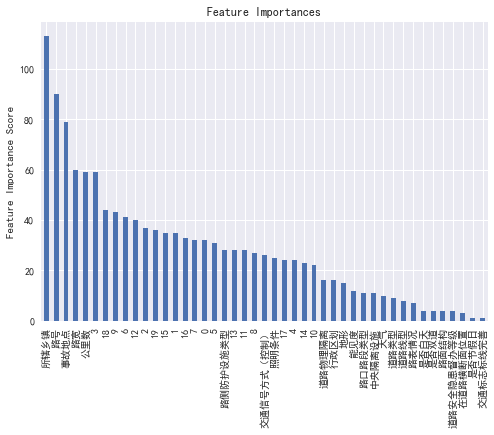

In [104]:
def modelfit(alg, dtrain, dLabel,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):  
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        xgtrain = xgb.DMatrix(dtrain.values, label=dLabel.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds)#, show_progress=False，多分类metrics使用merror
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain,dLabel,eval_metric='merror')    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        



    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dLabel.values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    cvresult = pd.DataFrame(cvresult)
    print("Accuracy : %.4g" % (1-cvresult.iloc[-1][0]))
    print('test-auc-mean and test-auc-std and train-auc-mean and train-auc-std:')
    print(cvresult.iloc[-1][:])#
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    print(feat_imp)
    print(type(feat_imp))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return alg
    
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=3,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.7,
    #  reg_alpha=0.005,
    objective= 'multi:softmax',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
alg = modelfit(xgb1, feaFromOri, dataForCNNAndXG_train['事故类型'])

In [94]:
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(feaFromOri, dataForCNNAndXG_train['事故类型'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.60951, std: 0.03025, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.60339, std: 0.02337, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.61102, std: 0.01687, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.61707, std: 0.02135, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.61392, std: 0.03171, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.59730, std: 0.01908, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.60493, std: 0.02218, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.61857, std: 0.02523, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.61400, std: 0.02797, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.61405, std: 0.01961, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.61859, std: 0.02577, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.62164, std: 0.02550, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 5

In [170]:

#     a = sess.run(
#         tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(
#         tf.nn.max_pool(tf.nn.relu(\
#             tf.nn.conv2d(tf.reshape(tf.cast(x_train[:,:42],tf.float32),[-1, 14, 3, 1]), W_conv1,\
#             strides=[1, 1, 1, 1], padding='SAME'  )+ b_conv1),\
#             ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'),W_conv2,\
#             strides=[1, 1, 1, 1], padding='SAME'  )+ b_conv2),\
#             ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'))
#     a = np.reshape(a,[697,336])
#     a = pd.DataFrame(a)
#     a['index'] = range(len(a))
#     b = pd.DataFrame(x_test[:,42:])
#     b['index'] = range(len(b))
#     b = pd.merge(left=a,right=b,left_on=['index'],right_on=['index'])
#     b.drop(['index'],axis=1,inplace=True)